In [2]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import LogNorm
import copy

# Fixing random state for reproducibility
np.random.seed(19680801)

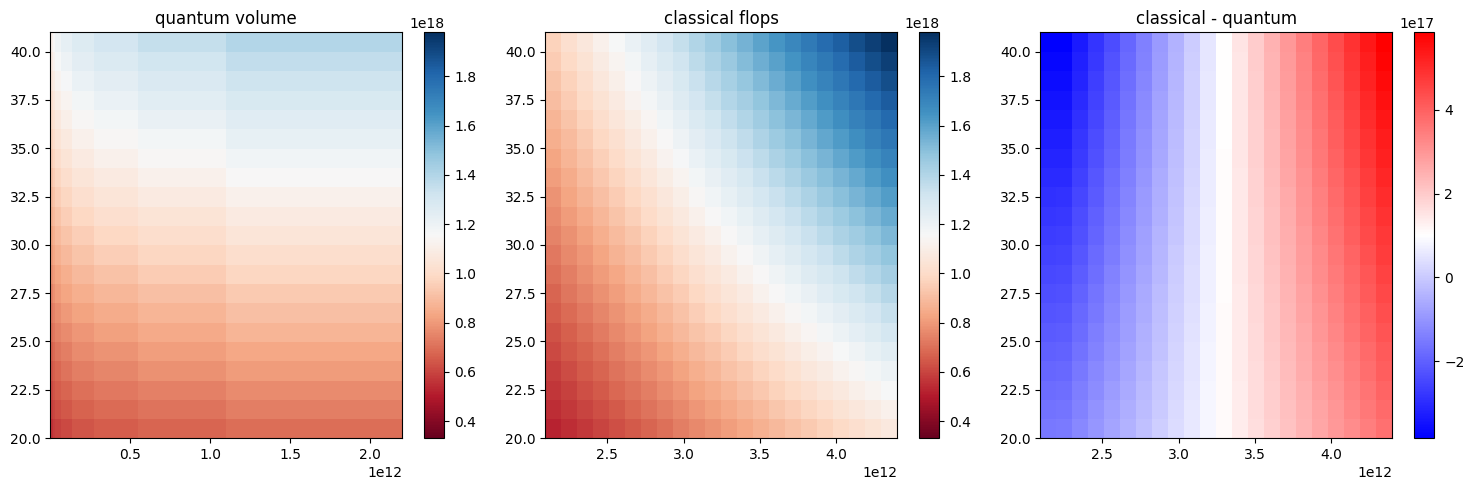

In [5]:
start = 20
sap_range = 21
k = 1000
epsilon = 0.01


ds = 1
dn = 1 # dimension equasion 2^n

bits = 10

s1, n = np.mgrid[start *ds: (start + sap_range) * ds + ds : ds, start *dn : (sap_range + start) * dn + dn : dn]
# the number of hamiltonian simulation
# here we assume that the one sparese decomposition is optimal, and
# is done in the application level, so the dependence on s
# is s, and there is no graph coloring cost for each hamiltonian simulation
nhs = np.sqrt(80 / 3) * np.pi * k**2 * s1 / epsilon**2 # number of hamiltonian simulation
q_alg_phs = bits + 2 * n + 2 # number of algorithmic qubits per hamiltonian simulation 
q_lgc_phs = 2 * q_alg_phs + np.ceil(np.sqrt(8 * q_alg_phs)) + 1 # number of logical qubits per hamiltonian simulation (because of layout in a 2D grid)
log_depth_phs = 10 * n + 609 # logical depth per hamiltonian simulation

volumn = nhs * q_lgc_phs * log_depth_phs
volumn = volumn[:-1, :-1]
volumn_min, volumn_max = volumn.min(), volumn.max()

# now the classical part
maxN = 2**(start  + sap_range)
minN = 2**start
dN = maxN / sap_range
s, N = np.mgrid[start*ds : (start + sap_range) * ds + ds : ds, start * dN : (start + sap_range) * dN + dN : dN]
flops = 1 / 2 * k * np.log(2 / epsilon) * (4 * N * s + 14 * N)
flops = flops[:-1, :-1]
flops_min , flops_max = flops.min(), flops.max()
# nhs = nhs[:-1, :-1]
# nhs_min , nhs_max = nhs.min(), nhs.max()

# now the classical - quantum
diff = copy.deepcopy(flops)

for i in range(sap_range):
    for j in range(sap_range + 1):
        # print(np.ceil(np.log2(N[i,j])))
        diff[i, j] = diff[i,j] - volumn[i, (np.floor(np.log2(N[i,j])) - start  - 1).astype(int)]
diff_min, diff_max = diff.min(), diff.max()

all_min = np.min([volumn_min, flops_min])
all_max = np.max([volumn_max, flops_max])

# print("volumn_min", volumn_min)
# print("volumn_max", volumn_max)
# print("flops_min", flops_min)
# print("flops_max", flops_max)

# 创建一个单独的子图
fig, axs = plt.subplots(1,3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1]})

# 使用 pcolor 绘制
ax = axs[0]
expn = 2**n
c = ax.pcolor(expn, s1, volumn, cmap='RdBu', vmin=all_min, vmax=all_max)
ax.set_title('quantum volume')
fig.colorbar(c, ax=ax)


ax = axs[1]
c = ax.pcolor(N, s, flops, cmap='RdBu', vmin=all_min, vmax=all_max)
ax.set_title('classical flops')
fig.colorbar(c, ax=ax)

ax = axs[2]
c = ax.pcolor(N, s, diff, cmap="bwr", vmin=diff_min, vmax=diff_max)
ax.set_title("classical - quantum")
fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

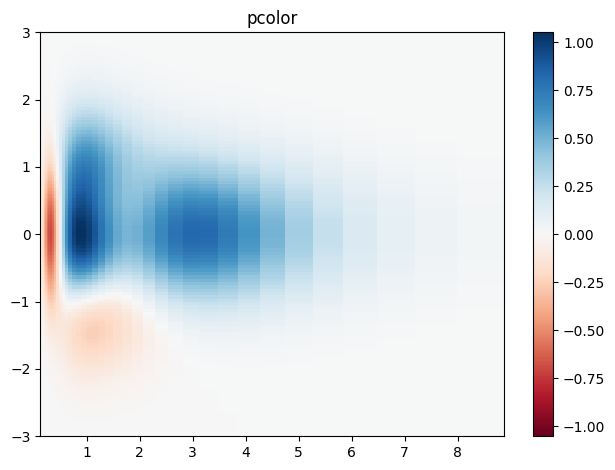

In [ ]:


# make these smaller to increase the resolution
dx, dy = 0.15, 0.05

# generate 2D grids for the x & y bounds
y, x = np.mgrid[-3:3+dy:dy, -3:3+dx:dx]
z = (1 - x/2 + x**5 + y**3) * np.exp(-x**2 - y**2)

# x and y are bounds, so z should be the value *inside* those bounds.
# therefore, remove the last row and column from the z array.
z = z[:-1, :-1]

z_min, z_max = -abs(z).max(), abs(z).max()

# 创建一个单独的子图
fig, ax = plt.subplots()

# 使用 pcolor 绘制
expx = 2**x
c = ax.pcolor(expx, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolor')

# 添加颜色条
fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()
